In [62]:
import numpy as np
from pathlib import Path
import os
from matplotlib import pyplot as plt
import geopandas as gpd
import contextily as cx
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from telenvi import vector_tools as vt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

- Download and explore dataset

In [5]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [21]:
x, y = mnist["data"], mnist["target"]
print(type(x), type(y))
print(x.shape, y.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(70000, 784) (70000,)


In [20]:
x_ar = np.array(x)
y_ar = np.array(y)
print(x_ar.shape, y_ar.shape)

(70000, 784) (70000,)


The 10th instance is labelled as 3
The 382th feature in this instance represent a pixel with a value of 146. 
It is located in (18, 13) in the 2d space.


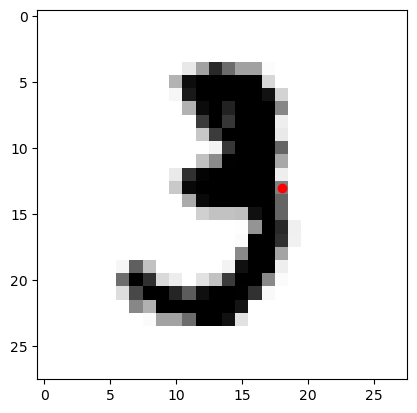

In [58]:
# Define a test index for an instance
test_instance_index = 10

# Define indexes for a feature (a pixel)
feature_column_index, feature_row_index = 18, 13

# Catch image dimensions
height = width = np.sqrt(len(x_ar[test_instance_index])).astype('int8')

# Reshape in 2D format
test_instance = x_ar[test_instance_index].reshape((height, width))

# Display as an image
ax = plt.imshow(test_instance, cmap='Greys')

plt.scatter(feature_column_index, feature_row_index, c='red')

# Display the instance label
print(f"The {test_instance_index}th instance is labelled as {y[test_instance_index]}")

# Display a feature value
print(f"The {feature_row_index * 28 + feature_column_index}th feature in this instance represent a pixel with a value of {test_instance[feature_row_index][feature_column_index]}. \nIt is located in {(feature_column_index, feature_row_index)} in the 2d space.")

In [75]:
def show_instance(ds, index, cmap='Greys', figsize=(4,4), height=28, width=28):
    instance_to_show = ds[index].reshape(height, width)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(instance_to_show, cmap=cmap)
    return ax

In [59]:
type(y_ar[0])

str

In [60]:
y_ar = y_ar.astype('int8')
type(y_ar[0])

numpy.int8

In [61]:
len(x_ar)

70000

- Divide the dataset in train / test set

In [79]:
# help(train_test_split)

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x_ar, y_ar, test_size=0.2, random_state=1)

Associated label = 4


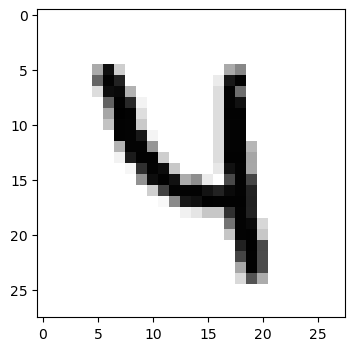

In [97]:
index = 5
show_instance(x_train, index)
print(f"Associated label = {y_train[index]}")

- Binary classifier

In [104]:
from sklearn.linear_model import SGDClassifier

# Define the target digit. 
# Our model will only be capable to detect if 
# a given instance represent this digit or not
digit_to_detect = 8

# Transform the labels by True or False
y_train_equals_to_digit_to_detect = (y_train == digit_to_detect)

# y_train_t[foo] == True --> x_train[foo] represent a digit equal to digit_to_detect
# y_train_t[foo] == False--> x_train[foo] represent another digit


In [95]:
# Create a SGD classifier instance 
sgd_clf = SGDClassifier(random_state=1)

# Use its .fit method to train it
sgd_clf.fit(
    x = x_train, # The instances 
    y = y_train_equals_to_digit_to_detect # The associated labels : True or False)
)

pass

SGDClassifier(random_state=1)

Text(0.5, 0.98, 'SGD Classifier predictions | Digit 8')

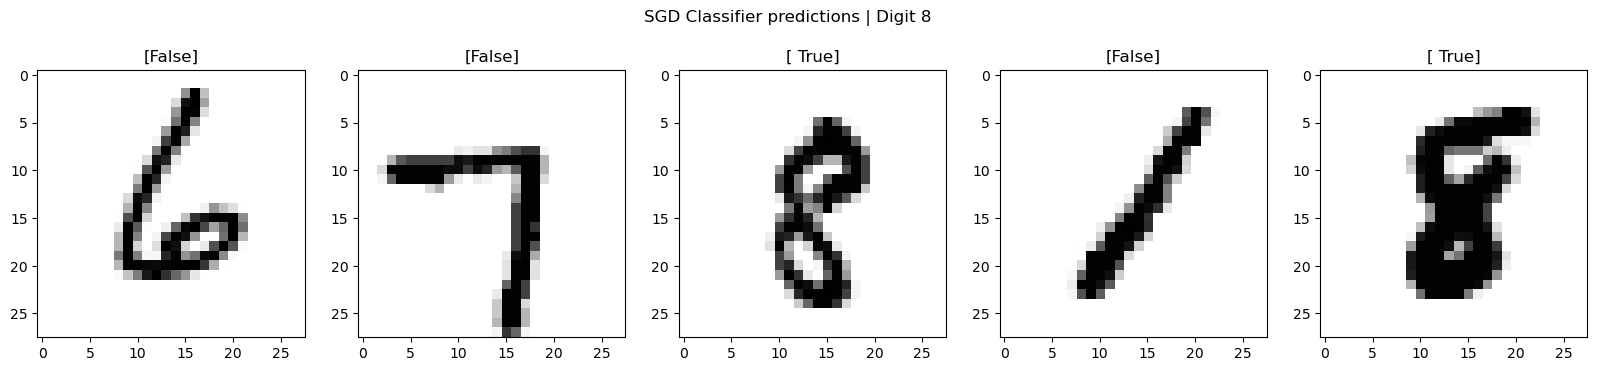

In [121]:
import random

def instance_show_digit(instance):
    """
    Apply the binary classifier on an instance located in x_train
    to the index_to_investigate position
    """

    # The model analyze this instance to see if it's or not equal to the digit
    return sgd_clf.predict([instance])

# Test with different digits
num_tests = 5
fig, axes = plt.subplots(1, num_tests, figsize=(20, 4))
for i in range(0, num_tests):

    # Choose an instance randomly in the x_test set
    random_instance = random.choice(x_test)

    # Display the instance analyzed
    axes[i].imshow(random_instance.reshape((28,28)), cmap='Greys')

    # Analyze it with the model
    res = instance_show_digit(random_instance)

    # Show the result
    axes[i].set_title(str(res))

fig.suptitle(f"SGD Classifier predictions | Digit {digit_to_detect}")